# Overview

Evaluate the streak removal results with closed source version.

In [1]:
import optuna

## Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the GPU device ID to 0 for this notebook session
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import h5py

this_dir = os.path.abspath("")
data_dir = os.path.join(this_dir, '../../tests/bm3dornl-data')
datafile = os.path.join(data_dir, 'tomostack_small.h5')

# Load the data and select a noisy sinogram
with h5py.File(datafile, 'r') as f:
    tomo_stack_noisy = f['noisy_tomostack'][:]
    tomo_stack_clean = f["clean_tomostack"][:]

## Evaluate the __full__ process

In [3]:
study_name = "bm3dornl_parameter_tunning"
db_file_path = f"{study_name}_full.db"
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{db_file_path}",
    direction="minimize",
    load_if_exists=True,
)

[I 2024-07-15 15:25:02,421] Using an existing study with name 'bm3dornl_parameter_tunning' instead of creating a new one.


In [4]:
# show the top 5 best trials as a dataframe
df = study.trials_dataframe().sort_values("value")

df.head(5)

number     value             datetime_start          datetime_complete  \
652     652  0.137426 2024-07-13 17:05:46.897074 2024-07-13 17:10:34.473419   
599     599  0.137628 2024-07-13 12:47:14.100308 2024-07-13 12:51:53.649080   
782     782  0.137635 2024-07-14 02:55:19.752850 2024-07-14 02:59:38.679425   
984     984  0.137643 2024-07-14 16:59:20.138614 2024-07-14 17:03:53.137416   
881     881  0.137677 2024-07-14 09:39:13.169665 2024-07-14 09:43:58.725578   

                  duration  params_cut_off_distance  \
652 0 days 00:04:47.576345                       41   
599 0 days 00:04:39.548772                       36   
782 0 days 00:04:18.926575                       34   
984 0 days 00:04:32.998802                       36   
881 0 days 00:04:45.555913                       40   

     params_num_patches_per_group  params_patch_size  params_shrinkage_factor  \
652                            54                  7                 0.045783   
599                            52                  7                 0.040407   
782                            54                  7                 0.041970   
984                            53                  7                 0.045808   
881                            56                  7                 0.046066   

     params_stride     state  
652              2  COMPLETE  
599              2  COMPLETE  
782              2  COMPLETE  
984              2  COMPLETE  
881              2  COMPLETE

Based on the results, these should be the default parameters:

In [5]:
block_matching_kwargs: dict = {
    "patch_size": (7, 7),
    "stride": 2,
    "background_threshold": 0.0,
    "cut_off_distance": (40, 40),
    "num_patches_per_group": 54,
    "padding_mode": "circular",
}

filter_kwargs: dict = {
    "filter_function": "fft",
    "shrinkage_factor": 4e-2,
}

kwargs = {
    "mode": "full",
    "block_matching_kwargs": block_matching_kwargs,
    "filter_kwargs": filter_kwargs,
}

In [6]:
import bm3d_streak_removal as bm3dsr
from bm3dornl.bm3d import (
  estimate_noise_free_sinogram,
  bm3d_ring_artifact_removal,
  bm3d_ring_artifact_removal_ms,
)

In [7]:
def view_slice(idx: int, ms_iter: int=5):
    # input
    sino_noisy = tomo_stack_noisy[:, idx, :]
    # estimate
    sino_estimate = estimate_noise_free_sinogram(sino_noisy)
    # bm3d (ref)
    print("BM3D")
    sino_bm3d_attenuated = bm3dsr.extreme_streak_attenuation(
        data=sino_noisy,
        # extreme_streak_iterations=3,
        # extreme_detect_lambda=4.0,
        # extreme_detect_size=9,
        # extreme_replace_size=2,
    )
    sino_bm3d = bm3dsr.multiscale_streak_removal(
        data=sino_bm3d_attenuated,
        max_bin_iter_horizontal=0,
        bin_vertical=0,
        # filter_strength=1.0,
        # use_slices=True,
        # slice_sizes=None,
        # slice_step_sizes=None,
        # denoise_indices=None,
    )[:, 0, :]
    sino_bm3d_ms = bm3dsr.multiscale_streak_removal(
        data=sino_bm3d_attenuated,
        max_bin_iter_horizontal=ms_iter,
        bin_vertical=0,
        # filter_strength=1.0,
        # use_slices=True,
        # slice_sizes=None,
        # slice_step_sizes=None,
        # denoise_indices=None,
    )[:, 0, :]
    # bm3d_ornl
    print("BM3D ORNL")
    sino_bm3dornl = bm3d_ring_artifact_removal(sino_noisy, **kwargs)
    sino_bm3dornl_ms = bm3d_ring_artifact_removal_ms(sino_noisy, k=ms_iter, **kwargs)

    # visualization
    # row_0: input, sino_bm3d, sino_bm3d_ms, sino_bm3d_ms - input, sino_bm3d_ms - sino_bm3d
    # row_1: estimate, sino_bm3dornl, sino_bm3dornl_ms, sino_bm3dornl_ms - input, sino_bm3dornl_ms - sino_bm3dornl
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    axs[0, 0].imshow(sino_noisy, cmap='gray')
    axs[0, 0].set_title("Input")
    axs[0, 1].imshow(sino_bm3d, cmap='gray')
    axs[0, 1].set_title("BM3D")
    axs[0, 2].imshow(sino_bm3d_ms, cmap='gray')
    axs[0, 2].set_title("BM3D MS")
    diff = sino_bm3d_ms - sino_noisy
    cval = np.max(np.abs(diff))
    axs[0, 3].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[0, 3].set_title(f"BM3D MS - Input: cval={cval}")
    diff = sino_bm3d_ms - sino_bm3d
    cval = np.max(np.abs(diff))
    axs[0, 4].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[0, 4].set_title(f"BM3D MS - BM3D: cval={cval}")
    axs[1, 0].imshow(sino_estimate, cmap='gray')
    axs[1, 0].set_title("Estimate")
    axs[1, 1].imshow(sino_bm3dornl, cmap='gray')
    axs[1, 1].set_title("BM3D ORNL")
    axs[1, 2].imshow(sino_bm3dornl_ms, cmap='gray')
    axs[1, 2].set_title("BM3D ORNL MS")
    diff = sino_bm3dornl_ms - sino_noisy
    cval = np.max(np.abs(diff))
    axs[1, 3].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[1, 3].set_title(f"BM3D ORNL MS - Input: cval={cval}")
    diff = sino_bm3dornl_ms - sino_bm3dornl
    cval = np.max(np.abs(diff))
    axs[1, 4].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[1, 4].set_title(f"BM3D ORNL MS - BM3D ORNL: cval={cval}")
    return fig, axs

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.07392440497247064'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.0727140247000689'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.058044739067554474'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.048273541033267975'}>]],
       dtype=object))

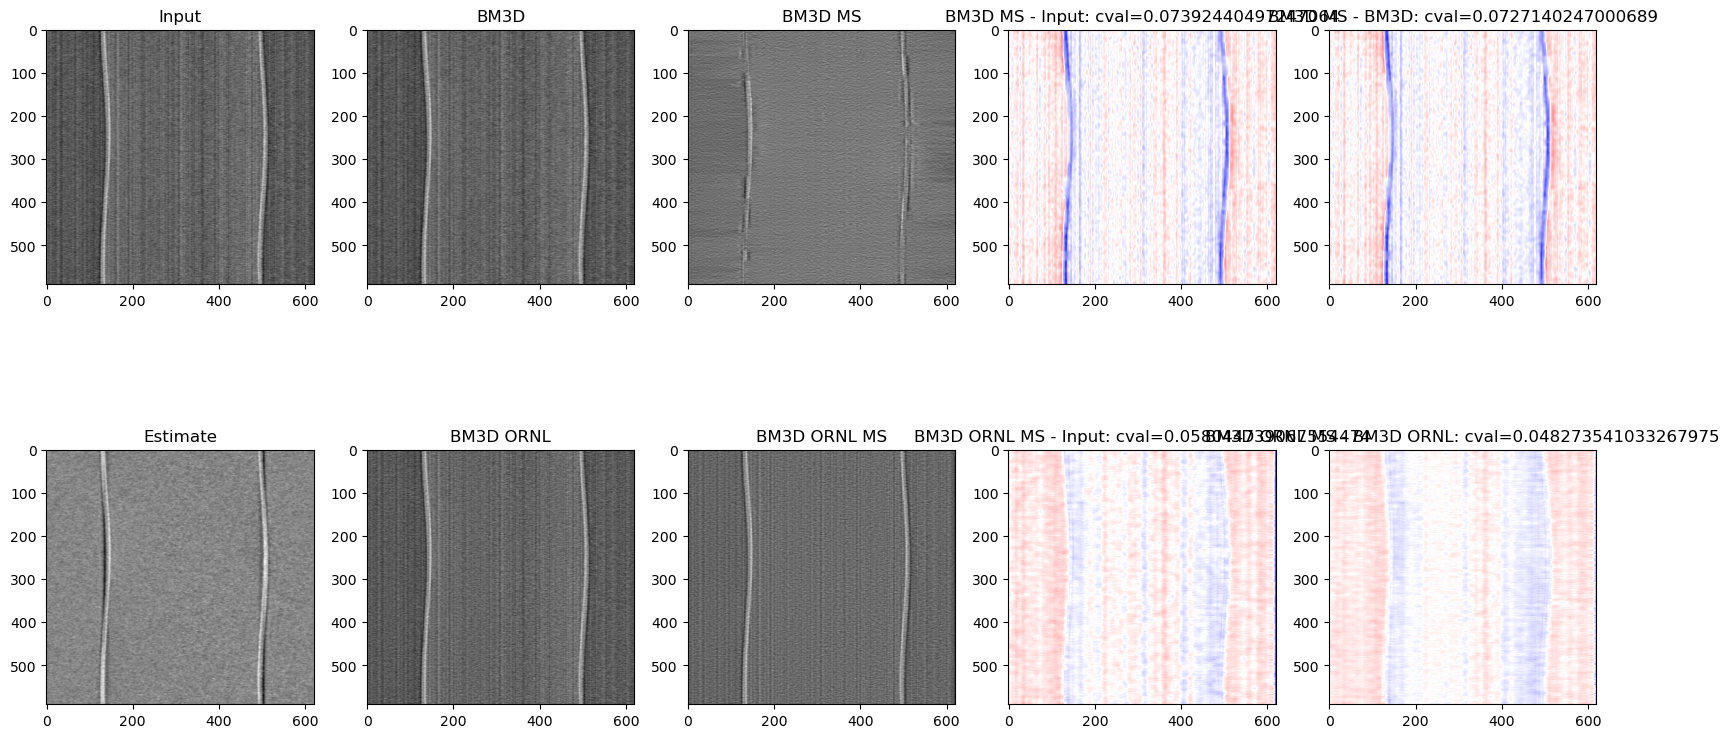

In [8]:
view_slice(10)

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.059336615559300865'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.05873345871304464'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.0984405055642128'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.08322227001190186'}>]],
       dtype=object))

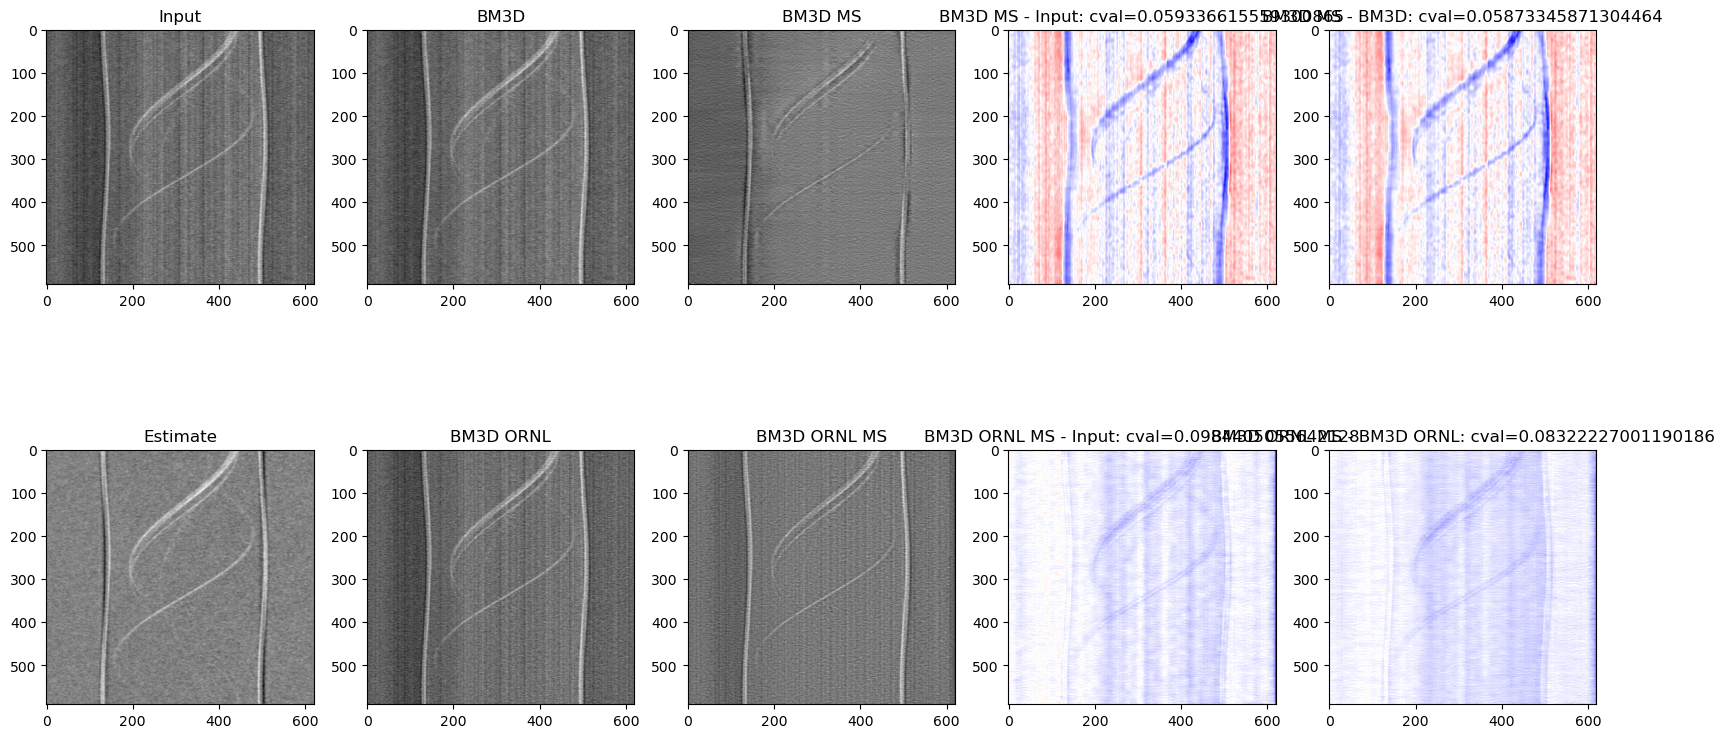

In [9]:
view_slice(53)

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.1595237617953662'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.15943553000188593'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.3992234766483307'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.3931375741958618'}>]],
       dtype=object))

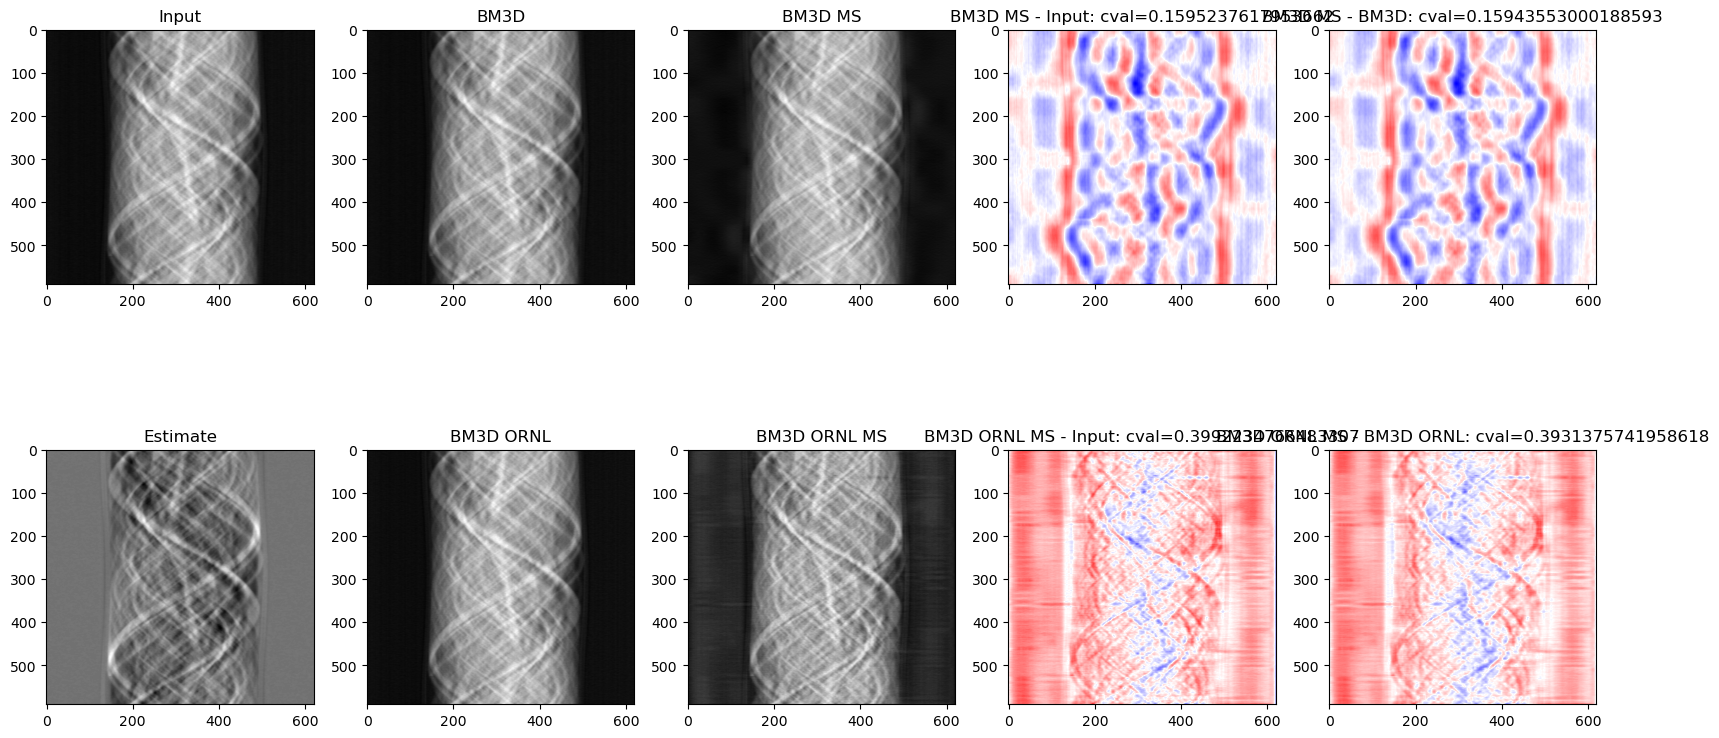

In [10]:
view_slice(146)

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.19739099225628598'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.19772517828169267'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.5116762518882751'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.4328707456588745'}>]],
       dtype=object))

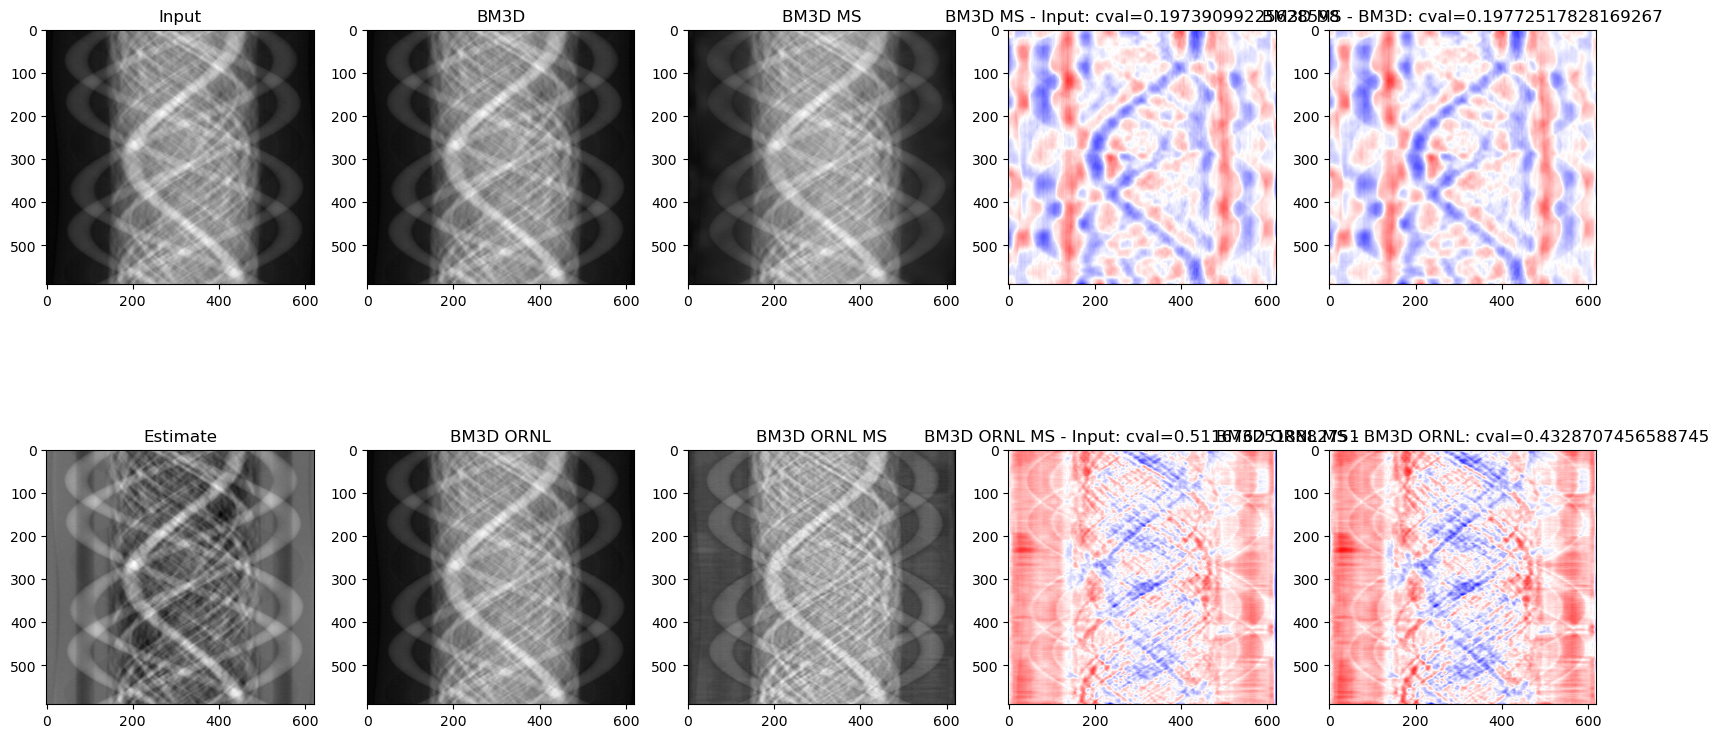

In [11]:
view_slice(458)

## Evaluate simple

In [12]:
study_name = "bm3dornl_parameter_tunning"
db_file_path = f"{study_name}.db"
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{db_file_path}",
    direction="minimize",
    load_if_exists=True,
)

[I 2024-07-15 15:44:27,694] Using an existing study with name 'bm3dornl_parameter_tunning' instead of creating a new one.


In [13]:
# show the top 5 best trials as a dataframe
df = study.trials_dataframe().sort_values("value")

df.head(5)

number     value             datetime_start          datetime_complete  \
570     570  0.121383 2024-07-11 10:49:05.442427 2024-07-11 10:49:21.818941   
630     630  0.121384 2024-07-11 11:06:09.692506 2024-07-11 11:06:27.180293   
566     566  0.121386 2024-07-11 10:47:47.915942 2024-07-11 10:48:04.232106   
588     588  0.121386 2024-07-11 10:54:33.098404 2024-07-11 10:54:50.067566   
560     560  0.121387 2024-07-11 10:46:10.690263 2024-07-11 10:46:27.228819   

                  duration  params_cut_off_distance  \
570 0 days 00:00:16.376514                       32   
630 0 days 00:00:17.487787                       34   
566 0 days 00:00:16.316164                       32   
588 0 days 00:00:16.969162                       34   
560 0 days 00:00:16.538556                       32   

     params_num_patches_per_group  params_patch_size  params_shrinkage_factor  \
570                            64                  7                99.764921   
630                            64                  7                97.779944   
566                            64                  7                99.760864   
588                            64                  7                97.915022   
560                            64                  7                99.926053   

     params_stride     state  
570              4  COMPLETE  
630              4  COMPLETE  
566              4  COMPLETE  
588              4  COMPLETE  
560              4  COMPLETE

In [14]:
block_matching_kwargs: dict = {
    "patch_size": (7, 7),
    "stride": 2,
    "background_threshold": 0.0,
    "cut_off_distance": (40, 40),
    "num_patches_per_group": 64,
    "padding_mode": "circular",
}

filter_kwargs: dict = {
    "filter_function": "fft",
    "shrinkage_factor": 4e-2,
}

kwargs = {
    "mode": "simple",
    "block_matching_kwargs": block_matching_kwargs,
    "filter_kwargs": filter_kwargs,
}

In [15]:
def view_slice(idx: int, ms_iter: int=5):
    # input
    sino_noisy = tomo_stack_noisy[:, idx, :]
    # estimate
    sino_estimate = estimate_noise_free_sinogram(sino_noisy)
    # bm3d (ref)
    print("BM3D")
    sino_bm3d_attenuated = bm3dsr.extreme_streak_attenuation(
        data=sino_noisy,
        # extreme_streak_iterations=3,
        # extreme_detect_lambda=4.0,
        # extreme_detect_size=9,
        # extreme_replace_size=2,
    )
    sino_bm3d = bm3dsr.multiscale_streak_removal(
        data=sino_bm3d_attenuated,
        max_bin_iter_horizontal=0,
        bin_vertical=0,
        # filter_strength=1.0,
        # use_slices=True,
        # slice_sizes=None,
        # slice_step_sizes=None,
        # denoise_indices=None,
    )[:, 0, :]
    sino_bm3d_ms = bm3dsr.multiscale_streak_removal(
        data=sino_bm3d_attenuated,
        max_bin_iter_horizontal=ms_iter,
        bin_vertical=0,
        # filter_strength=1.0,
        # use_slices=True,
        # slice_sizes=None,
        # slice_step_sizes=None,
        # denoise_indices=None,
    )[:, 0, :]
    # bm3d_ornl
    print("BM3D ORNL")
    sino_bm3dornl = bm3d_ring_artifact_removal(sino_noisy, **kwargs)
    sino_bm3dornl_ms = bm3d_ring_artifact_removal_ms(sino_noisy, k=ms_iter, **kwargs)

    # visualization
    # row_0: input, sino_bm3d, sino_bm3d_ms, sino_bm3d_ms - input, sino_bm3d_ms - sino_bm3d
    # row_1: estimate, sino_bm3dornl, sino_bm3dornl_ms, sino_bm3dornl_ms - input, sino_bm3dornl_ms - sino_bm3dornl
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    axs[0, 0].imshow(sino_noisy, cmap='gray')
    axs[0, 0].set_title("Input")
    axs[0, 1].imshow(sino_bm3d, cmap='gray')
    axs[0, 1].set_title("BM3D")
    axs[0, 2].imshow(sino_bm3d_ms, cmap='gray')
    axs[0, 2].set_title("BM3D MS")
    diff = sino_bm3d_ms - sino_noisy
    cval = np.max(np.abs(diff))
    axs[0, 3].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[0, 3].set_title(f"BM3D MS - Input: cval={cval}")
    diff = sino_bm3d_ms - sino_bm3d
    cval = np.max(np.abs(diff))
    axs[0, 4].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[0, 4].set_title(f"BM3D MS - BM3D: cval={cval}")
    axs[1, 0].imshow(sino_estimate, cmap='gray')
    axs[1, 0].set_title("Estimate")
    axs[1, 1].imshow(sino_bm3dornl, cmap='gray')
    axs[1, 1].set_title("BM3D ORNL")
    axs[1, 2].imshow(sino_bm3dornl_ms, cmap='gray')
    axs[1, 2].set_title("BM3D ORNL MS")
    diff = sino_bm3dornl_ms - sino_noisy
    cval = np.max(np.abs(diff))
    axs[1, 3].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[1, 3].set_title(f"BM3D ORNL MS - Input: cval={cval}")
    diff = sino_bm3dornl_ms - sino_bm3dornl
    cval = np.max(np.abs(diff))
    axs[1, 4].imshow(diff, cmap='bwr', vmin=-cval, vmax=cval)
    axs[1, 4].set_title(f"BM3D ORNL MS - BM3D ORNL: cval={cval}")
    return fig, axs

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.07392440497247064'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.0727140247000689'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.0729663148522377'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.04386303573846817'}>]],
       dtype=object))

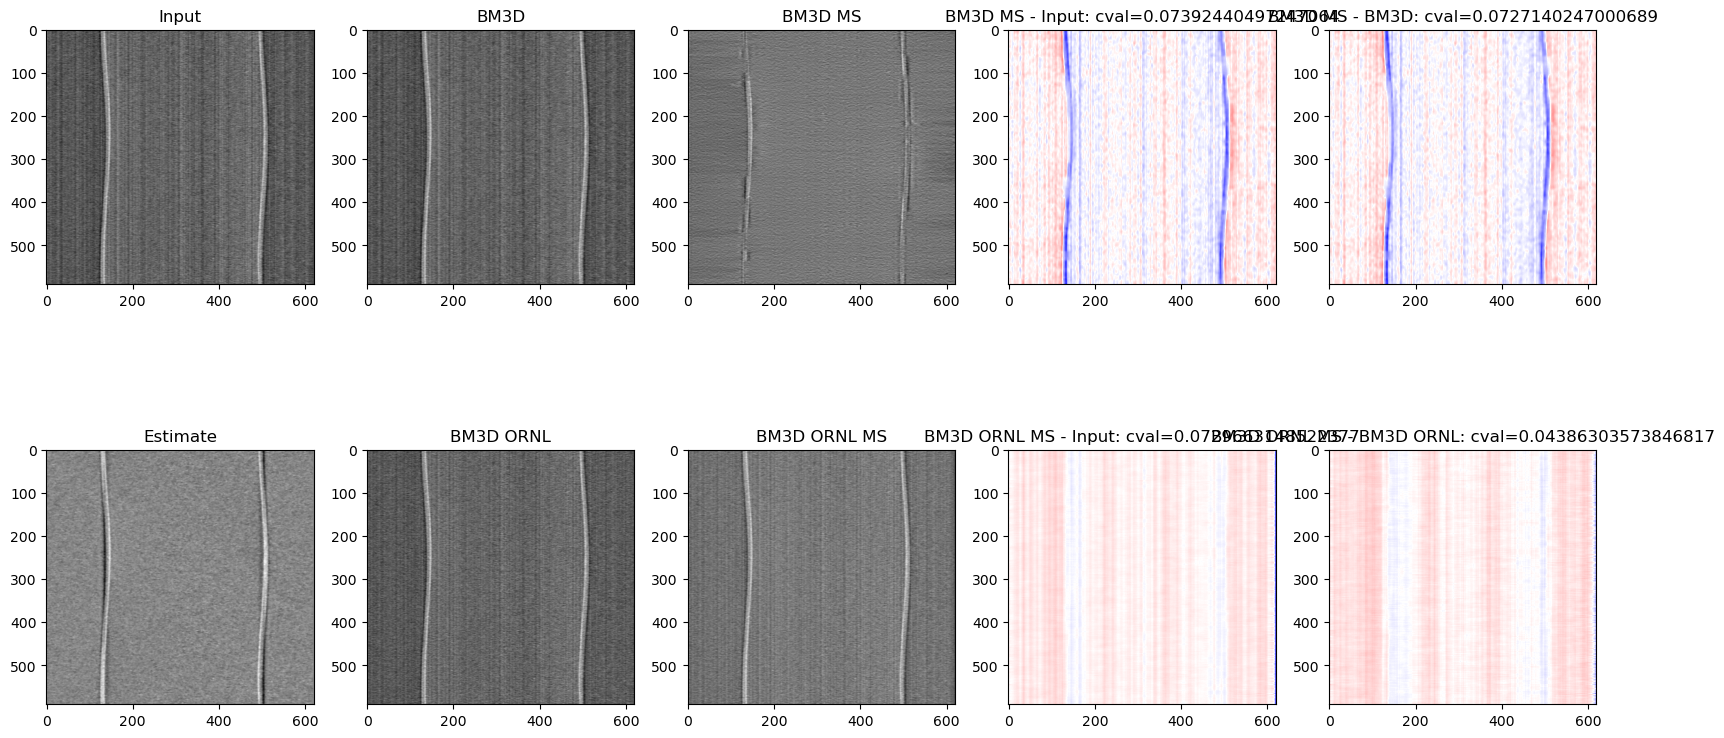

In [16]:
view_slice(10)

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.059336615559300865'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.05873345871304464'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.10998557507991791'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.0777701884508133'}>]],
       dtype=object))

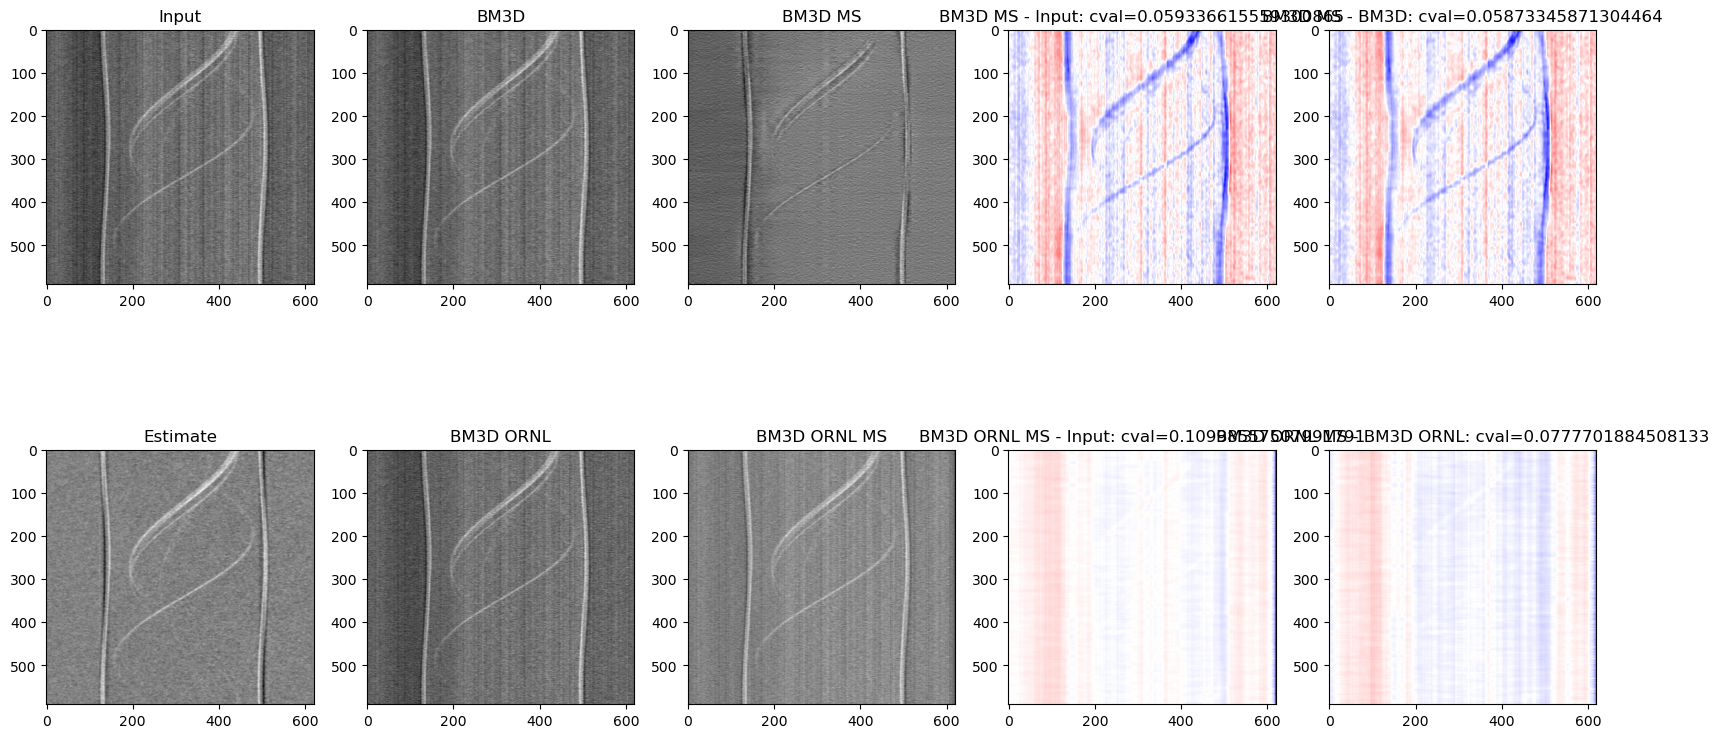

In [17]:
view_slice(53)

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.1595237617953662'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.15943553000188593'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.46993058919906616'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.4464591145515442'}>]],
       dtype=object))

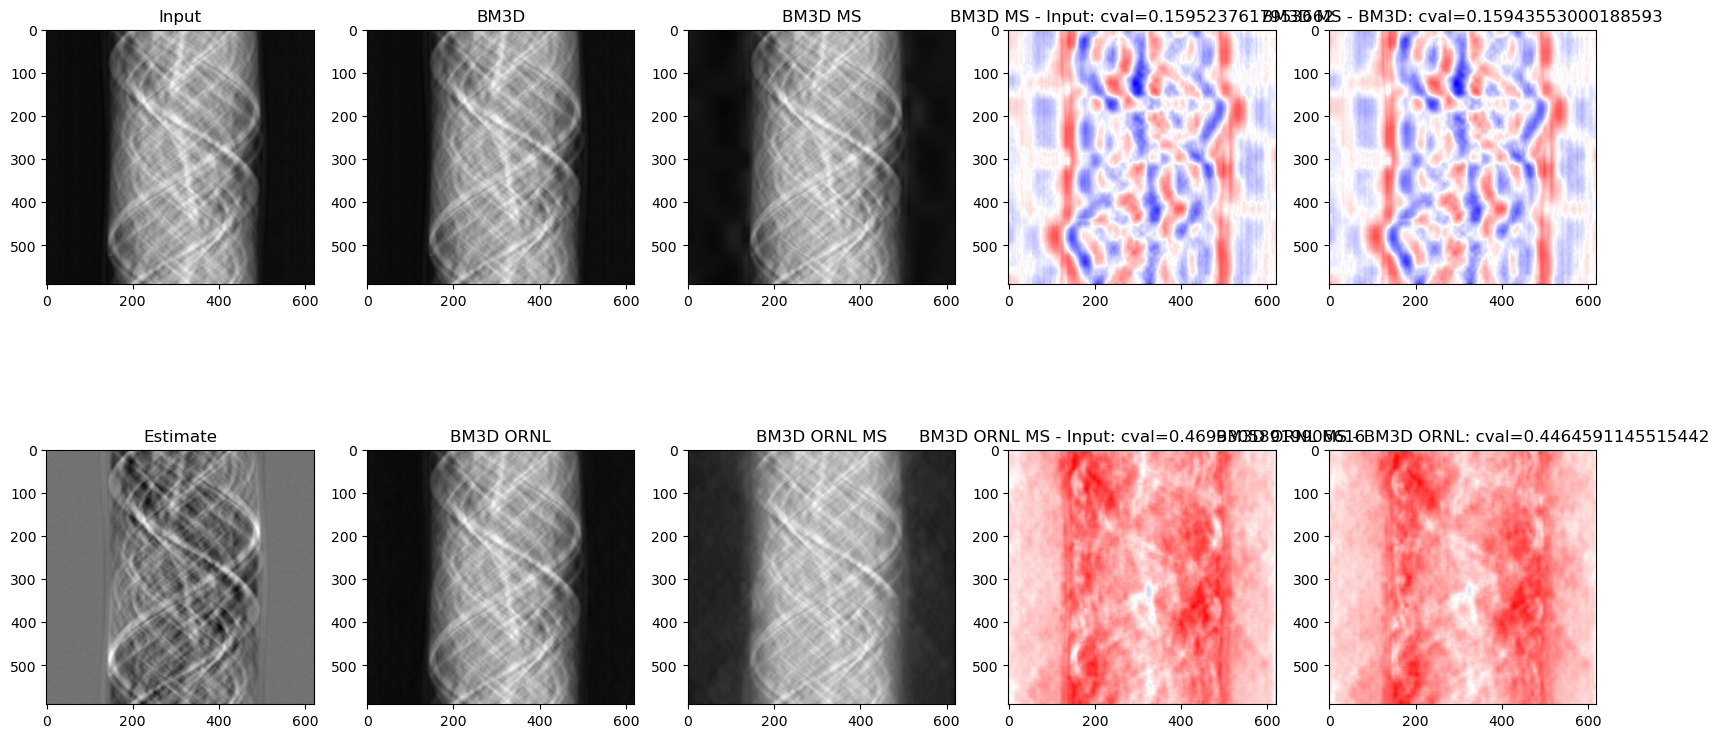

In [18]:
view_slice(146)

BM3D
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
BM3D ORNL


(<Figure size 2000x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'Input'}>,
         <Axes: title={'center': 'BM3D'}>,
         <Axes: title={'center': 'BM3D MS'}>,
         <Axes: title={'center': 'BM3D MS - Input: cval=0.19739099225628598'}>,
         <Axes: title={'center': 'BM3D MS - BM3D: cval=0.19772517828169267'}>],
        [<Axes: title={'center': 'Estimate'}>,
         <Axes: title={'center': 'BM3D ORNL'}>,
         <Axes: title={'center': 'BM3D ORNL MS'}>,
         <Axes: title={'center': 'BM3D ORNL MS - Input: cval=0.44119134545326233'}>,
         <Axes: title={'center': 'BM3D ORNL MS - BM3D ORNL: cval=0.42464813590049744'}>]],
       dtype=object))

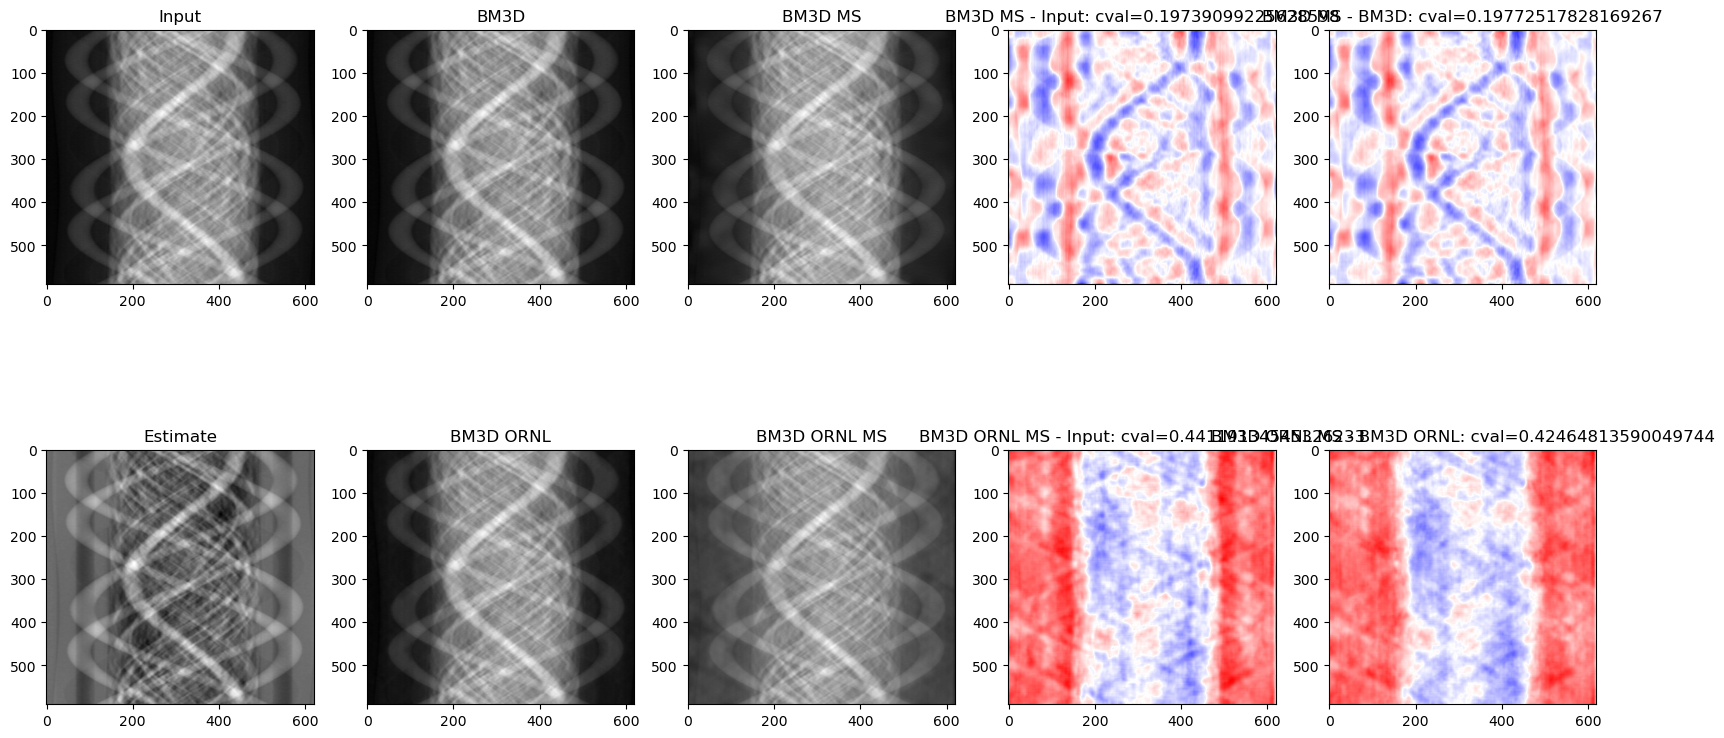

In [19]:
view_slice(458)